In [1]:
from astropy.coordinates import SkyCoord
import numpy as np
from IntegralQuery import SearchQuery, IntegralQuery, Filter, Range
from IntegralPointingClustering import ClusteredQuery
import astropy.io.fits as fits
from astropy.table import Table
from pyspi.utils.response.spi_pointing import construct_sc_matrix, construct_scy
from pyspi.utils.geometry import cart2polar, polar2cart
from datetime import datetime
import matplotlib.pyplot as plt
import math
from numba import njit


In [2]:
# Lists of scw_ids for different date ranges

radius_around_crab = 3

p = SkyCoord(83.6333, 22.0144, frame="icrs", unit="deg")
searchquerry = SearchQuery(position=p, radius=f"{radius_around_crab} degree")
cat = IntegralQuery(searchquerry)

f1 = Filter(SCW_TYPE="POINTING",
            TIME=Range("2006-01-01T00:00:00", "2007-01-01T00:00:00"))
f2 = Filter(SCW_TYPE="POINTING",
            TIME=Range("2011-01-01T00:00:00", "2012-01-01T00:00:00"))
f3 = Filter(SCW_TYPE="POINTING",
            TIME=Range("2016-01-01T00:00:00", "2017-01-01T00:00:00"))

scw_ids1 = cat.apply_filter(f1,return_coordinates=True, remove_duplicates=True)
scw_ids2 = cat.apply_filter(f2,return_coordinates=True, remove_duplicates=True)
scw_ids3 = cat.apply_filter(f3,return_coordinates=True, remove_duplicates=True)

In [3]:
# Clusters of size 2

min_angle_dif = 2.0
max_angle_dif = 2.5
max_time_dif = 0.3

cq1 = ClusteredQuery(scw_ids1,
                    angle_weight=0.,
                    time_weight=1./max_time_dif,
                    max_distance=1.,
                    min_ang_distance=min_angle_dif,
                    max_ang_distance=max_angle_dif,
                    cluster_size_range = (2,2),
                    failed_improvements_max = 3,
                    suboptimal_cluster_size = 1,
                    close_suboptimal_cluster_size = 1).get_clustered_scw_ids()
cq2 = ClusteredQuery(scw_ids2,
                    angle_weight=0.,
                    time_weight=1./max_time_dif,
                    max_distance=1.,
                    min_ang_distance=min_angle_dif,
                    max_ang_distance=max_angle_dif,
                    cluster_size_range = (2,2),
                    failed_improvements_max = 3,
                    suboptimal_cluster_size = 1,
                    close_suboptimal_cluster_size = 1).get_clustered_scw_ids()
cq3 = ClusteredQuery(scw_ids3,
                    angle_weight=0.,
                    time_weight=1./max_time_dif,
                    max_distance=1.,
                    min_ang_distance=min_angle_dif,
                    max_ang_distance=max_angle_dif,
                    cluster_size_range = (2,2),
                    failed_improvements_max = 3,
                    suboptimal_cluster_size = 1,
                    close_suboptimal_cluster_size = 1).get_clustered_scw_ids()

cluster1 = cq1[2][0] #['042200080010', '042200150010']
cluster2 = cq2[2][0] #['101900600010', '101900650010']
cluster3 = cq3[2][0] #['164400170010', '164400160010']

print(cluster1, cluster2, cluster3)
# Expect: ['042200080010', '042200150010'] ['101900600010', '101900650010'] ['164400150010', '164400220010']

['042200080010', '042200150010'] ['101900600010', '101900650010'] ['164400150010', '164400220010']


In [4]:
# Compare pointing coordinates

# Load all necessary data
pointing_id1 = cluster1[0]
pointing_id2 = cluster1[1]

from astroquery.heasarc import Heasarc, Conf
integral_query = Heasarc()
Conf.server.set('https://www.isdc.unige.ch/browse/w3query.pl')
query_dict = {}
query_dict["mission"] = "integral_rev3_scw"
query_dict["position"] = p
query_dict["radius"] = f"{radius_around_crab} degree"
query_dict["sortvar"] = "START_DATE"
query_dict["resultmax"] = 0
r = integral_query.query_region(**query_dict)
r.convert_bytestring_to_unicode()
pa = r.to_pandas()
pointing_heasarc_info1 = pa[pa["SCW_ID"]==pointing_id1]
pointing_heasarc_info2 = pa[pa["SCW_ID"]==pointing_id2]


with fits.open("crab_data/0422/pointing.fits") as file:
    t = Table.read(file[1])
    pointing_fits_info1 = t[t["PTID_ISOC"]==pointing_id1[:8]]
    pointing_fits_info2 = t[t["PTID_ISOC"]==pointing_id2[:8]]


# Start and End Times
# See https://www.isdc.unige.ch/integral/support/faq.cgi?DATA-007
import astropy.time as at
print(f"Pointing {pointing_id1}")
print("HEASARC times:") 
print(f"{pointing_heasarc_info1['START_DATE'].iloc[0]} to {pointing_heasarc_info1['END_DATE'].iloc[0]}")
print("Fits times:")
print(f'''{at.Time(f'{pointing_fits_info1["TSTART"][0]+2451544.5}', format='jd').iso[:-4]} to {at.Time(f'{pointing_fits_info1["TSTOP"][0]+2451544.5}', format='jd').iso[:-4]}''')
print()
print(f"Pointing {pointing_id2}")
print("HEASARC times:") 
print(f"{pointing_heasarc_info2['START_DATE'].iloc[0]} to {pointing_heasarc_info2['END_DATE'].iloc[0]}")
print("Fits times:")
print(f'''{at.Time(f'{pointing_fits_info2["TSTART"][0]+2451544.5}', format='jd').iso[:-4]} to {at.Time(f'{pointing_fits_info2["TSTOP"][0]+2451544.5}', format='jd').iso[:-4]}''')

print()
print(
    "The Fits times are in TT, which differ from UTC by 00:01:05. "
    "If the HEASARC times are in UTC, then SCW 042200150010 matches perfectly. "
    "Generally speaking, the time difference between the times given by HEASARC and those in the fits files is "
    "inconsistent, with science windows usually being a little shorter using the fits times. "
    "When in disagreement, I suppose the times in the fits files are preferable."
)
print()
print()


# SPI Orientation
# Get misalignment matrix
from pyspi.io.package_data import get_path_of_internal_data_dir
matrix_file = os.path.join(get_path_of_internal_data_dir(), 'inst_misalign_20050328.fits')
with fits.open(matrix_file) as f:
    spi_idx = f['GNRL-IROT-MOD'].data['INSTRUMENT'] == 'SPI'
    matrix_raw = f['GNRL-IROT-MOD'].data['MATRIX'][spi_idx]
    misalignment_matrix = matrix_raw.reshape((3,3))
    iv_mm = np.linalg.inv(misalignment_matrix)

# Calculate INTEGRAL coordinates from SPI coordinates
rax1, decx1, raz1, decz1 = pointing_fits_info1["RA_SPIX", "DEC_SPIX", "RA_SPIZ", "DEC_SPIZ"].as_array()[0]
ray1, decy1 = construct_scy(rax1, decx1, raz1, decz1)
sc_matrix1 = construct_sc_matrix(rax1, decx1, ray1, decy1, raz1, decz1)
ic_matrix1 = np.dot(iv_mm, sc_matrix1)
irax1, idecx1 = cart2polar(ic_matrix1[0, : ])

# Compare results
print(f"Pointing {pointing_id1}")
print("HEASARC x-orientation:") 
print(f"{pointing_heasarc_info1['RA_X'].iloc[0]}, {pointing_heasarc_info1['DEC_X'].iloc[0]}")
print("Fits x-orientation:")
print(f"{irax1:.6f}, {idecx1:.6f}")
print()

# Repeat for second pointing
rax2, decx2, raz2, decz2 = pointing_fits_info2["RA_SPIX", "DEC_SPIX", "RA_SPIZ", "DEC_SPIZ"].as_array()[0]
ray2, decy2 = construct_scy(rax2, decx2, raz2, decz2)
sc_matrix2 = construct_sc_matrix(rax2, decx2, ray2, decy2, raz2, decz2)
ic_matrix2 = np.dot(iv_mm, sc_matrix2)
irax2, idecx2 = cart2polar(ic_matrix2[0, : ])

print(f"Pointing {pointing_id2}")
print("HEASARC x-orientation:") 
print(f"{pointing_heasarc_info2['RA_X'].iloc[0]}, {pointing_heasarc_info2['DEC_X'].iloc[0]}")
print("Fits x-orientation:")
print(f"{irax2:.6f}, {idecx2:.6f}")
print()
print(
    "The orientation coordinates in the HEASARC Query thus specify the orientation of INTEGRAL, and not SPI. "
    "This may prove to be problematic if we wish for precise requirements in the clustering algorithm."
)

Pointing 042200080010
HEASARC times:
2006-03-28 20:40:15 to 2006-03-28 21:10:15
Fits times:
2006-03-28 20:42:08 to 2006-03-28 21:11:26

Pointing 042200150010
HEASARC times:
2006-03-29 00:24:32 to 2006-03-29 00:54:33
Fits times:
2006-03-29 00:25:37 to 2006-03-29 00:55:38

The Fits times are in TT, which differ from UTC by 00:01:05. If the HEASARC times are in UTC, then SCW 042200150010 matches perfectly. Generally speaking, the time difference between the times given by HEASARC and those in the fits files is inconsistent, with science windows usually being a little shorter using the fits times. When in disagreement, I suppose the times in the fits files are preferable.




Pointing 042200080010
HEASARC x-orientation:
80.854958, 23.445110
Fits x-orientation:
80.854956, 23.445110

Pointing 042200150010
HEASARC x-orientation:
82.973495, 23.935888
Fits x-orientation:
82.973496, 23.935888

The orientation coordinates in the HEASARC Query thus specify the orientation of INTEGRAL, and not SPI. This may prove to be problematic if we wish for precise requirements in the clustering algorithm.


In [14]:
import numpy as np
from pyspi.utils.function_utils import find_response_version
from pyspi.utils.response.spi_response_data import ResponseDataRMF
from pyspi.utils.response.spi_response import ResponseRMFGenerator
from pyspi.utils.response.spi_drm import SPIDRM
from pyspi.utils.livedets import get_live_dets
from astromodels import Powerlaw, Log_uniform_prior, Uniform_prior, PointSource, SpectralComponent


def fit_crab_2_pointings(t_start1,
                         t_elapsed1,
                         ebins1,
                         counts1,
                        #  sc_matrix1,
                         t_start2,
                         t_elapsed2,
                         ebins2,
                         counts2,
                        #  sc_matrix2,
                         downscale_factor,
                         model_bins):
    ein = np.linspace(18, 3000, model_bins)
    assert type(downscale_factor) == type(3), "downscale_factor is not an integer"
    assert downscale_factor >= 1, "downscale_factor is not greater or equal to 1"
    
    num_bins1 = (len(ebins1)-1) // downscale_factor
    te = np.zeros(num_bins1+1)
    tc = np.zeros((19, num_bins1))
    for i in range(num_bins1):
        te[i] = ebins1[i*downscale_factor]
        tc[ : , i] = np.sum(counts1[ : , i*downscale_factor : (i+1)*downscale_factor], 1)
    te[-1] = ebins1[num_bins1*downscale_factor]
    ebins1 = te
    counts1 = tc
    
    num_bins2 = (len(ebins2)-1) // downscale_factor
    te = np.zeros(num_bins2+1)
    tc = np.zeros((19, num_bins2))
    for i in range(num_bins2):
        te[i] = ebins2[i*downscale_factor]
        tc[ : , i] = np.sum(counts2[ : , i*downscale_factor : (i+1)*downscale_factor], 1)
    te[-1] = ebins2[num_bins2*downscale_factor]
    ebins2 = te
    counts2 = tc
    
    version1 = find_response_version(t_start1)
    version2 = find_response_version(t_start2)
    assert version1 == version2, "Response versions are not equal"
    
    dets1 = get_live_dets(time=t_start1, event_types=["single"])
    dets2 = get_live_dets(time=t_start2, event_types=["single"])
    assert np.array_equal(dets1, dets2), "Active detectors are not the same"
    counts1 = counts1[dets1]
    counts2 = counts2[dets1]
    
    # assert np.array_equal(ebins1, ebins2), "Energy bins are not equal"
    
    rsp_base = ResponseDataRMF.from_version(version1)
    
    ra_crab, dec_crab = 83.6333, 22.0144
    # vec_crab = polar2cart(ra_crab, dec_crab)
    # spi_crab1 = np.dot(np.linalg.inv(sc_matrix1), vec_crab)
    # spi_crab2 = np.dot(np.linalg.inv(sc_matrix2), vec_crab)
    
    sds1 = []
    sds2 = []
    for d in dets1:
        rsp1 = ResponseRMFGenerator.from_time(t_start1,  d,
                                                ebins1, ein,
                                                rsp_base)
        sd1 = SPIDRM(rsp1, ra_crab, dec_crab)
        sds1.append(sd1)
        
        rsp2 = ResponseRMFGenerator.from_time(t_start2,  d,
                                                ebins2, ein,
                                                rsp_base)
        sd2 = SPIDRM(rsp2, ra_crab, dec_crab)
        sds2.append(sd2)
        
    
    pl = Powerlaw()
    pl.index = -2.08
    pl.K = 9.3#6.44*10**-4
    pl.xiv = 1

    pl.K.prior = Log_uniform_prior(lower_bound=0.001, upper_bound=1000)
    pl.index.prior = Uniform_prior(lower_bound=-4, upper_bound=0)

    component1 = SpectralComponent('pl',shape=pl)
    ps = PointSource('plline',ra=94.67830, dec=-70.99905, components=[component1])

    spec = ps(ein)

    spec_binned = (ein[1:]-ein[:-1])*(spec[:-1]+spec[1:])/2
    
    
    @njit
    def bmaxba(m1, m2, t1, t2, C1, C2):
        first = C1+C2-(m1+m2)*(t1+t2)
        root = (C1+C2+(m1-m2)*(t1+t2))**2-4*C1*(m1-m2)*(t1+t2)
        res = (first+np.sqrt(root))/(2*(t1+t2))
        if res < 0:
            return 0
        return res
    
    matrices1 = np.array([])
    sd_x, sd_y = sds1[0].matrix.T.shape
    for sd in sds1:
        matrices1=np.append(matrices1,sd.matrix.T)
    matrices1=matrices1.reshape((len(dets1), sd_x, sd_y))

    matrices2 = np.array([])
    for sd in sds2:
        matrices2=np.append(matrices2,sd.matrix.T)
    matrices2=matrices2.reshape((len(dets1), sd_x, sd_y))

    @njit
    def logLcore(spec_binned):
        logL=0
        for j in range(len(dets1)):
            m1 = np.dot(spec_binned, matrices1[j])
            m2 = np.dot(spec_binned, matrices2[j])
            for i in range(len(m1)):
                bm = bmaxba(m1[i], m2[i], t_elapsed1, t_elapsed2, counts1[j, i], counts2[j, i])
                logL += (counts1[j,i]*math.log(t_elapsed1*(m1[i]+bm))+
                        counts2[j,i]*math.log(t_elapsed2*(m2[i]+bm))-
                        t_elapsed1*(m1[i]+bm)-
                        t_elapsed2*(m2[i]+bm))
        return logL

    def logLba_mult(trial_values, ndim=None, params=None):
        pl.index = trial_values[1]
        pl.K = trial_values[0]
        spec = pl(ein)
        spec_binned = (ein[1:]-ein[:-1])*(spec[:-1]+spec[1:])/2
        return logLcore(spec_binned)
    
    
    def prior(params, ndim=None, nparams=None):
        for i, (parameter_name, parameter) in enumerate(
            ps.free_parameters.items()
        ):
            try:
                params[i] = parameter.prior.from_unit_cube(params[i])

            except AttributeError:
                raise RuntimeError(
                    "The prior you are trying to use for parameter %s is "
                    "not compatible with sampling from a unitcube"
                    % parameter_name
                )

    
    import pymultinest
    import os
    if not os.path.exists("./chains"):
        os.mkdir("chains")
    sampler = pymultinest.run(
                        logLba_mult, prior, 2, 2, n_live_points=800, resume=False, verbose=True
                    )
    
    %matplotlib inline
    from chainconsumer import ChainConsumer


    def loadtxt2d(intext):
            try:
                return np.loadtxt(intext, ndmin=2)
            except:
                return np.loadtxt(intext)

    c = ChainConsumer()

    chain = loadtxt2d('./chains/1-post_equal_weights.dat')

    #c.add_chain(chain, parameters=['K', 'index', 'F', 'mu','sigma', '$z$'], name='yeah')
    c.add_chain(chain, parameters=['K', 'index', '$z$'], name='fit')
    
    c.plotter.plot(filename=f"crab_parameter_fit_{t_start1}_{downscale_factor}.pdf", 
                parameters=['K', 'index'],
                truth=[9.3, -2.08],
                log_scales=[]);
    
    
    
    
    
    
    
    



In [15]:
import astropy.time as at
def extract_relevant_information(path, p_id):
    with fits.open(f"{path}/pointing.fits") as file:
        t = Table.read(file[1])
        index = np.argwhere(t["PTID_ISOC"]==p_id[:8])[0][0]

        pointing_info = t[index]
        
        t1 = at.Time(f'{pointing_info["TSTART"]+2451544.5}', format='jd').datetime
        time_start = datetime.strftime(t1,'%y%m%d %H%M%S')
        t2 = at.Time(f'{pointing_info["TSTOP"]+2451544.5}', format='jd').datetime
        time_elapsed = (t2-t1).seconds
        
        # rax, decx, raz, decz = pointing_info["RA_SPIX", "DEC_SPIX", "RA_SPIZ", "DEC_SPIZ"]
        # ray, decy = construct_scy(rax, decx, raz, decz)
        # sc_matrix = construct_sc_matrix(rax, decx, ray, decy, raz, decz)
        
    with fits.open(f"{path}/energy_boundaries.fits") as file:
        t = Table.read(file[1])
        
        energy_bins = np.append(t["E_MIN"], t["E_MAX"][-1])
    
    with fits.open(f"{path}/evts_det_spec.fits") as file:
        t = Table.read(file[1])
        
        num_dets = 19
        counts = np.zeros((num_dets, len(energy_bins)-1))
        for i in range(num_dets):
            counts[i, : ] = t["COUNTS"][index*85 + i]

    return time_start, time_elapsed, energy_bins, counts#, sc_matrix

Using the irfs that are valid between 04/07/17 08:20:06 and 09/02/19 09:59:57 (YY/MM/DD HH:MM:SS)
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  800
 dimensionality =    2
 *****************************************************
 Starting MultiNest
 generating live points
 live points generated, starting sampling
Acceptance Rate:                        0.996483
Replacements:                                850
Total Samples:                               853
Nested Sampling ln(Z):            **************
Importance Nested Sampling ln(Z): 8770730.027016 +/-  0.999414
Acceptance Rate:                        0.992282
Replacements:                                900
Total Samples:                               907
Nested Sampling ln(Z):            **************
Importance Nested Sampling ln(Z): 8770749.003550 +/-  0.999449
Acceptance Rate:                        0.974359
Replacements:  

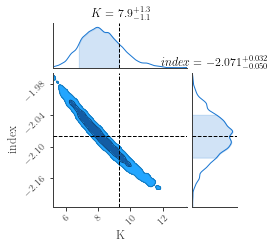

In [16]:
path = "crab_data/0422"
pid1 = "042200080010"
pid2 = '042200150010'
fit_crab_2_pointings(
    *extract_relevant_information(path, pid1),
    *extract_relevant_information(path, pid2),
    1, 500
)

Using the irfs that are valid between 04/07/17 08:20:06 and 09/02/19 09:59:57 (YY/MM/DD HH:MM:SS)
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  800
 dimensionality =    2
 *****************************************************
 Starting MultiNest
 generating live points
 live points generated, starting sampling
Acceptance Rate:                        0.998825
Replacements:                                850
Total Samples:                               851
Nested Sampling ln(Z):            **************
Importance Nested Sampling ln(Z): ************** +/-  0.999407
Acceptance Rate:                        0.995575
Replacements:                                900
Total Samples:                               904
Nested Sampling ln(Z):            **************
Importance Nested Sampling ln(Z): ************** +/-  0.999442
Acceptance Rate:                        0.988554
Replacements:  

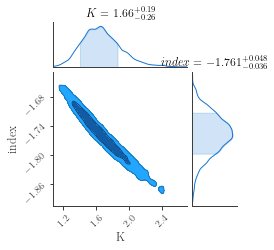

In [17]:
path = "crab_data/0422"
pid1 = "042200080010"
pid2 = '042200150010'
fit_crab_2_pointings(
    *extract_relevant_information(path, pid1),
    *extract_relevant_information(path, pid2),
    64, 100
)

Using the irfs that are valid between 10/05/27 12:45:00 and present (YY/MM/DD HH:MM:SS)
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  800
 dimensionality =    2
 *****************************************************
 Starting MultiNest
 generating live points
 live points generated, starting sampling
Acceptance Rate:                        0.998825
Replacements:                                850
Total Samples:                               851
Nested Sampling ln(Z):            **************
Importance Nested Sampling ln(Z): 4895019.773453 +/-  0.183815
Acceptance Rate:                        0.994475
Replacements:                                900
Total Samples:                               905
Nested Sampling ln(Z):            **************
Importance Nested Sampling ln(Z): 4895019.799300 +/-  0.180630
Acceptance Rate:                        0.988554
Replacements:            

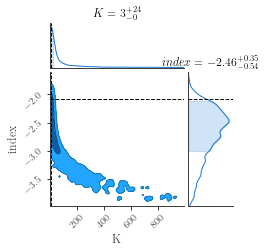

In [18]:
path = "crab_data/1019"
pid1 = "101900600010"
pid2 = '101900650010'
fit_crab_2_pointings(
    *extract_relevant_information(path, pid1),
    *extract_relevant_information(path, pid2),
    1, 500
)

Using the irfs that are valid between 10/05/27 12:45:00 and present (YY/MM/DD HH:MM:SS)
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  800
 dimensionality =    2
 *****************************************************
 Starting MultiNest
 generating live points
 live points generated, starting sampling
Acceptance Rate:                        0.998825
Replacements:                                850
Total Samples:                               851
Nested Sampling ln(Z):            **************
Importance Nested Sampling ln(Z): ************** +/-  0.166882
Acceptance Rate:                        0.992282
Replacements:                                900
Total Samples:                               907
Nested Sampling ln(Z):            **************
Importance Nested Sampling ln(Z): ************** +/-  0.162027
Acceptance Rate:                        0.981405
Replacements:            

Acceptance Rate:                        0.743318
Replacements:                               4700
Total Samples:                              6323
Nested Sampling ln(Z):            **************
Importance Nested Sampling ln(Z): ************** +/-  0.014870
Acceptance Rate:                        0.743815
Replacements:                               4750
Total Samples:                              6386
Nested Sampling ln(Z):            **************
Importance Nested Sampling ln(Z): ************** +/-  0.014701
Acceptance Rate:                        0.743955
Replacements:                               4800
Total Samples:                              6452
Nested Sampling ln(Z):            **************
Importance Nested Sampling ln(Z): ************** +/-  0.014540
Acceptance Rate:                        0.743538
Replacements:                               4804
Total Samples:                              6461
Nested Sampling ln(Z):            **************
Importance Nested Sampling 

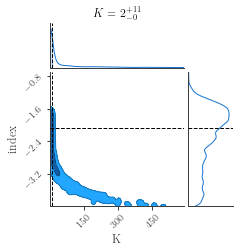

In [19]:
path = "crab_data/1019"
pid1 = "101900600010"
pid2 = '101900650010'
fit_crab_2_pointings(
    *extract_relevant_information(path, pid1),
    *extract_relevant_information(path, pid2),
    64, 100
)

Using the irfs that are valid between 10/05/27 12:45:00 and present (YY/MM/DD HH:MM:SS)
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  800
 dimensionality =    2
 *****************************************************
 Starting MultiNest
 generating live points
 live points generated, starting sampling
Acceptance Rate:                        0.998825
Replacements:                                850
Total Samples:                               851
Nested Sampling ln(Z):            **************
Importance Nested Sampling ln(Z): 4104916.846549 +/-  0.479705
Acceptance Rate:                        0.996678
Replacements:                                900
Total Samples:                               903
Nested Sampling ln(Z):            **************
Importance Nested Sampling ln(Z): 4104916.787238 +/-  0.479776
Acceptance Rate:                        0.989583
Replacements:            

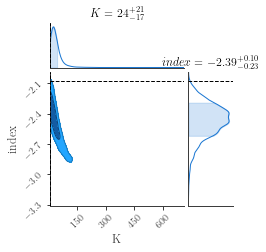

In [20]:
path = "crab_data/1644"
pid1 = '164400150010'
pid2 = '164400220010'
fit_crab_2_pointings(
    *extract_relevant_information(path, pid1),
    *extract_relevant_information(path, pid2),
    1, 500
)

Using the irfs that are valid between 10/05/27 12:45:00 and present (YY/MM/DD HH:MM:SS)
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  800
 dimensionality =    2
 *****************************************************
 Starting MultiNest
 generating live points
 live points generated, starting sampling
Acceptance Rate:                        1.000000
Replacements:                                850
Total Samples:                               850
Nested Sampling ln(Z):            **************
Importance Nested Sampling ln(Z): 9228944.870616 +/-  0.463380
Acceptance Rate:                        0.994475
Replacements:                                900
Total Samples:                               905
Nested Sampling ln(Z):            **************
Importance Nested Sampling ln(Z): 9228944.811064 +/-  0.462001
Acceptance Rate:                        0.984456
Replacements:            

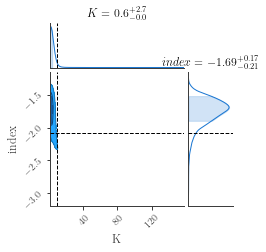

In [21]:
path = "crab_data/1644"
pid1 = '164400150010'
pid2 = '164400220010'
fit_crab_2_pointings(
    *extract_relevant_information(path, pid1),
    *extract_relevant_information(path, pid2),
    64, 100
)